# CATARC DATA IO

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 18 11:14:36 2018

@author: Shengjie

读取和写入数据
"""
#判断是否整数
def isInt(x):
    try:
        x=int(x)
        return isinstance(x,int)
    except ValueError:
        return False

#读取.csv文件中的数据
def dataReader(filename):
    '''
    从.csv文件中读取数据
    一般默认的.csv文件的内容为: 
        文件参数
        ...
        (序号  时间      位移   载荷)
        1, 0.00000, -0.00458, 17.56
        ...
    若不符合此格式可能产生读取错误! 
    参数列表: 
        filename  读取的文件名
    返回列表: 
        time_array  时间序列
        displacement  位移序列, 与时间序列相对应
        load  载荷序列, 与时间序列相对应
    '''
    
    import csv
    #read .csv file
    f_input=open(filename, encoding='utf-8')
    csv_reader=csv.reader(f_input)
    
    #arrays of displacement and load inputs
    time_array=[]
    displacement=[]
    load=[]

    #information


    for row in csv_reader:
        if isInt(row[0]):
            time_array.append(float(row[1]))
            displacement.append(float(row[2]))
            load.append(float(row[3]))
    
    f_input.close()
    return [time_array, displacement, load]

def setOutput(filename, N, t, X, y, num_input):
    '''
    将N个样本数据写到文件中
    输出为N+1行: 
        第一行为N, num_input
        第2~N行每行包含一个样本数据
    参数列表: 略
    '''
    
    #output
    import csv
    with open(filename, 'w', newline="") as f_out:
        #文件头
        csv_writer=csv.writer(f_out)
        csv_writer.writerow([N, num_input])
        #数据部分
        for line in range(N):
            thisline=X[line]
            thisline.insert(0, t[line])
            thisline.append(y[line])
            csv_writer.writerow(thisline)
        
    return

def setInput(filename):
    '''
    从文件中读取N个样本数据
    返回N, t, X, y
    返回列表: 略
    '''
    
    import csv
    with open(filename, 'r') as f_in:
        csv_reader=csv.reader(f_in)
        
        ii=0
        N=0
        num_input=0
        t=[]
        X=[]
        y=[]
        for line in csv_reader:
            if ii==0:
                N=int(line[0])
                num_input=int(line[1])
                if N==0:
                    break
                ii+=1
            else:
                t.append(float(line[0]))
                thisX=[]
                for i in range(num_input):
                    thisX.append(float(line[1+i]))
                X.append(thisX)
                y.append(float(line[num_input+1]))
            
    return [N, t, X, y, num_input]

def resultOutput(filename, y):
    '''
    输出预测的y值
    '''
    
    import csv
    with open(filename, 'w', newline="") as f_out:
        csv_writer=csv.writer(f_out)
        for i in range(len(y)):
            csv_writer.writerow([y[i]])
        
    return
print('done')

done


# CATART EDM

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 16 16:33:25 2018

@author: Shengjie

catarc关于减震器或衬套的EDM(Empirical Dynamics Methods)模型
默认假设读取时域上的位移-载荷, 训练一个MLP(Multi-Layer Perceptron)进行拟合
自定义函数: 
    isInt(x)  判断x是否为整数, 用于.csv文件的数据读取
    csvReader(filename)  从.csv文件中读取时间、位移和载荷的数据
    setGeneration( , , )  用给定参数生成数据集
    nnTraining()  用给定参数设置神经网络, 然后训练
    outputFigure()  用给定参数输出结果的图像
"""

#从原始数据生成监督学习样本, 然后将样本划分为训练集, 验证集和测试集
def setGeneration(data, num_input=10, num_input_X=10, num_input_F=0, \
                  time_sample=[0., 60.], time_test=[20., 30.], ratio_valid=0.2):
    '''
    将位移的数据displacement按照输入参数生成样本, 并划分为训练集X_train, 验证集X_valid, 测试集X_test
    time_array以及load生成对应的t_*和y_*
    参数列表: 
        time_array  时间序列
        displacement  位移序列, 与时间序列相对应
        load  载荷序列, 与时间序列相对应
        num_input  默认为10, 样本数据的维度, 或用于神经网络的输入神经元个数
        num_input_After  默认为0, 表示样本选取当前时间点之后的数据点个数, 非0的值是非物理的! 
        time_sample  默认为[0,60], 函数将选取该时间段内的样本作为总样本
        time_test  默认为[20,30], 函数将选取该时间段内的样本作为训练集
        ratio_valid  默认为0.2, 验证集占总样本的比例
    返回列表：
        N_train  训练集样本数目
        t_train  时间序列
        X_train  输入, 每个点是i时刻及之前的num_input-1个时刻的位移构成的数组
        y_train  输出, 对应load
        N_valid  验证集样本数目, 由验证集占总样本的比例随机选取
        t_valid  验证集, 时间序列
        X_valid  验证集, 位移输入
        y_valid  验证集, load输出
        N_test   测试集样本数目, 截取一段时间内的数据作为测试
        t_test   测试集, 时间序列
        X_test   测试集, 位移输入
        y_test   测试集, load输出
    注记: 数据的scaler目前放在神经网络模块里进行
    '''
    [time_array, displacement, load]=data
    
    from random import sample as random_sample
    
    t=[]
    X=[]
    y=[]
    
    #inR=num_input_After
    in_X = num_input_X
    in_F = num_input_F
    
    for i in range(in_X, len(time_array)):
        if time_array[i] >= time_sample[0] and time_array[i] < time_sample[1]:
            t.append(time_array[i])
            X.append(displacement[i - in_X:i + 1] + load[i - in_F:i])               #<--------
            y.append(load[i])
        
    #divide arrays into sets
    N=len(t)
    
    t_train=[]
    X_train=[]
    y_train=[]
    
    t_valid=[]
    X_valid=[]
    y_valid=[]
    
    t_test=[]
    X_test=[]
    y_test=[]
    
    t_notest=[]
    X_notest=[]
    y_notest=[]
    
    #测试集
    for i in range(N):
        #choose data in 20.0s~30.0s
        if t[i] >= time_test[0] and t[i] < time_test[1]:
            t_test.append(t[i])
            X_test.append(X[i])
            y_test.append(y[i])
        else:
            t_notest.append(t[i])
            X_notest.append(X[i])
            y_notest.append(y[i])
            
    N_test=len(t_test)
        
    #不用于测试的样本
    N_notest  = len(t_notest)
    N_valid   = int(ratio_valid*N)
    seq_valid = random_sample(range(N_notest), N_valid)
    seq_valid.sort()
    
    index=0
    for i in range(N_notest):
        if index < N_valid and i == seq_valid[index]:
            t_valid.append(t_notest[i])
            X_valid.append(X_notest[i])
            y_valid.append(y_notest[i])
            index +=1
        else:
            t_train.append(t_notest[i])
            X_train.append(X_notest[i])
            y_train.append(y_notest[i])
    
    N_train=len(t_train)
    
    #scaler
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    #fit training data
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    if N_valid!=0:
        X_valid=scaler.transform(X_valid)
    X_test=scaler.transform(X_test)
    
    #returns
    return [N_train, t_train, X_train, y_train, N_valid, t_valid, X_valid, y_valid, \
            N_test, t_test, X_test, y_test]

#用训练集、验证集训练MLP, 并给出在训练集上的结果
def nnTraining(N_train, t_train, X_train, y_train, nn_hidden_layer_sizes=[20, ], nn_max_iter=2000, optimizer=False):
    '''
    通过从filename中读入数据并生成训练集、验证集(暂无)和测试集, 进行神经网络的训练
    给出预测的值和均方根
    
    参数列表:  
        N_train 训练集样本数目
        t_train  时间序列
        X_train  输入, 每个点是i时刻及之前的num_input-1个时刻的位移构成的数组
        y_train  输出, 对应load
        nn_hidden_layer_sizes  MLP隐层神经元个数
        nn_max_iter  最大迭代次数
    返回列表: 
        mlp  训练后的神经网络
    ''' 
    
    from sklearn.neural_network import MLPRegressor
    hidden_layer_sizes=nn_hidden_layer_sizes[:]
    '''
    mlp=MLPRegressor(hidden_layer_sizes=nn_hidden_layer_sizes, max_iter=nn_max_iter, \
                     solver='adam', alpha=1e-6, \
                     learning_rate='adaptive', learning_rate_init=1e-3, tol=1e-6)
    '''
    
    from sklearn.model_selection import cross_val_score
    if optimizer:#隐层单元数的优化
        layerSize_opt=0
        score_opt=-1.
        for m in range(20, 40, 10):
            mlp=MLPRegressor(hidden_layer_sizes=(m, ),
                             max_iter=nn_max_iter,
                             solver='adam', alpha=1e-6,
                             learning_rate='adaptive',
                             learning_rate_init=1e-3,
                             tol=1e-6)
            score=cross_val_score(mlp, X_train, y_train, cv=5)
            if layerSize_opt==0 or score.mean() < score_opt:
                score_opt=score.mean()
                layerSize_opt=m
                hidden_layer_sizes=[m, ]
                

    mlp=MLPRegressor(hidden_layer_sizes=nn_hidden_layer_sizes,
                     max_iter=nn_max_iter,
                     solver='adam',
                     alpha=1e-6,
                     learning_rate='adaptive',
                     learning_rate_init=1e-3,
                     tol=1e-6)
    mlp.fit(X_train, y_train)
    
    return [mlp, hidden_layer_sizes]

def modelSave(model, filename):
    from sklearn.externals import joblib
    f_name=filename+'_EDM.m'
    joblib.dump(model, f_name)
    
    return

def modelLoad(filename):
    from sklearn.externals import joblib
    f_name=filename+'_EDM.m'
    mlp=joblib.load(f_name)
    
    return mlp

#根据样本点X进行预测
def nnPredict(nn, X):
    '''
    根据训练好的神经网络进行预测
    参数列表: 
        nn  训练完成的MLPRegressor
        X   输入的样本点, 必须是一二维数组
    返回列表: 
        p_predict  预测值
    '''
    y_predict=nn.predict(X)
    return y_predict

#计算均方根误差
def rmsErrorCalculation(N, y, y_in):
    '''
    计算样本值和预测值之间的相对均方根误差
    参数列表: 
        N  样本数目
        y  样本输出值
        y_in  预测值
    返回列表: 
        error  相对均方根误差
    '''
    
    import math
    
    error=0.
    errorSquare=0.
    ySquare=0.
    
    for i in range(N):
        errorSquare+=(y_in[i]-y[i])**2/N
        ySquare+=y[i]**2/N
        
    error=math.sqrt(errorSquare)/math.sqrt(ySquare)
    
    return error

#输出图像
def figureOutput(fig_name, N, t, y, y_in, t_show, fig_linewidth=0.1, fig_dpi=600):
    '''
    计算样本值和预测值之间的相对均方根误差
    参数列表: 
        N  样本数目
        t  样本时间序列
        y  样本输出值
        y_in  预测值
    '''    
    
    import matplotlib.pyplot as plt
    
    t0=[]
    y0=[]
    y1=[]
    
    for i in range(N):
        if t[i]>=t_show[0] and t[i]<t_show[1]:
            t0.append(t[i])
            y0.append(y[i])
            y1.append(y_in[i])
        
    plt.plot(t0, y0, linewidth=fig_linewidth, color='black')
    plt.plot(t0, y1, linewidth=fig_linewidth, color='blue')
    plt.xlabel(u'Time(secs)', fontsize='small')
    plt.ylabel(u'N,N', fontsize='small')
    plt.grid(linestyle='--', linewidth=0.2, color='gray')
    plt.savefig(fig_name, dpi=fig_dpi)
    #plt.figure(facecolor='#0203e2')
    
    return

def spectrumOutput(fig_name, sampling_rate, N, t, t_show, y, y_in, fig_linewidth=0.1, fig_dpi=600):
    '''
    输出频谱
    参数列表: 
        同figureOutput
    '''
    
    import matplotlib.pyplot as spectrum
    import numpy as np
    
    fft_size=len(t)
    dt=t[fft_size-1]-t[0]
    sampling_rate=fft_size/dt
    
    y_f=np.fft.rfft(y)/fft_size
    y_in_f=np.fft.rfft(y_in)/fft_size
    
    freqs=np.linspace(0, dt*sampling_rate/2, fft_size/2+1)/dt
    
    y_fdb=20*np.log10(np.clip(np.abs(y_f), 1e-20, 1e200))
    y_in_fdb=20*np.log10(np.clip(np.abs(y_in_f), 1e-20, 1e200))
    
    #绘图
    spectrum.plot(freqs, y_fdb[0:len(freqs)], linewidth=fig_linewidth, color='black')
    spectrum.plot(freqs, y_in_fdb[0:len(freqs)], linewidth=fig_linewidth, color='blue')
    spectrum.ylim(-40, 40)
    spectrum.xlabel(u'Frequency(Hz)', fontsize='small')
    spectrum.ylabel(u'Amplitude(dB)', fontsize='small')
    spectrum.grid(linestyle='--', linewidth=0.2, color='gray')
    spectrum.savefig(fig_name, dpi=fig_dpi)
    
    return


from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

print('done')

done


# Main

(12288,) (12288,)
1.0 0.02127793515895499
30
12288 12288
12288
12288 12288
12288 12288
Predict time(secs):  0.00010059397512425979
RMSError= percent: 34.98%
CPU time(secs):  51.18675136566162


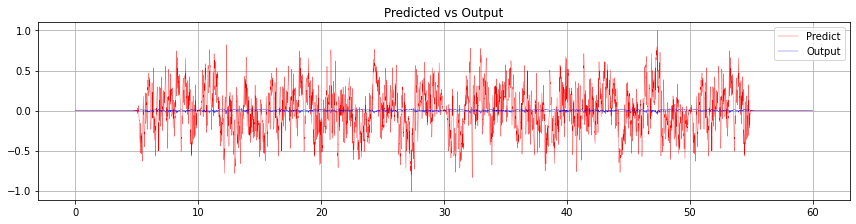

In [69]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 16 16:33:25 2018

@author: 49570

主程序
使用函数: 
    csvReader(filename)  从.csv文件中读取时间、位移和载荷的数据
    setGeneration( , , )  用给定参数生成数据集
    nnTraining()  用给定参数设置神经网络, 然后训练
    outputFigure()  用给定参数输出结果的图像
"""
import time
import catarc_EDM as EDM
import catarc_dataIO as IO
from sklearn.preprocessing import StandardScaler
import random
import numpy as np

tick1 = time.time()

#==============================================================================

filename            = 'JAC_Front_X_30Hz_5mm-01'
# filename            = 'CombineAllTests_out_Acc_out_out'
# filename            = 'CombineAllTests_out_Acc_out'
# filename            = 'A01_r02_A2W_raw_pt01to5hz'
# filename            = 'A01_r02_A2W_raw_5to50hz'
# filename            = 'A01_r02_A2W_vel_pt01to5hz'
# filename            = 'A01_r02_A2W_vel_5to50hz'



#edm样本参数

edm_num_input_X      = 50
edm_num_input_F      = 0
#edm_num_input_X
edm_num_input        = edm_num_input_X + edm_num_input_F + 1
edm_optimizer        = False
#edm_num_input_After = 0
edm_time_sample      = [0., 60.]
edm_time_test        = [20., 50.]
edm_ratio_valid      = 0.1

#神经网络参数
# edm_hidden_layer_sizes=[150, ]
multiplier              = 100
edm_hidden_layer_sizes  = [1 * multiplier,
                           2 * multiplier,
                           2 * multiplier,
                           5 * multiplier,
                           5 * multiplier,
                           5 * multiplier,
                           5 * multiplier,
                           5 * multiplier,
                           2 * multiplier,
                           2 * multiplier,
                           1 * multiplier ]

edm_max_iter            = 20000

#分析参数
edm_time_show           = [27., 28.]
edm_fig_name            = filename + '_t_' + str(edm_time_show[0]) + '_' + str(edm_time_show[1])

#==============================================================================
#根据参数划分样本

#读取数据
edmData                 = IO.dataReader(filename + '.csv')
# print(max(edmData[1]))
# print(max(edmData[2]))

a_np = np.array(edmData[1]) /max(edmData[1])
b_np = np.array(edmData[2]) /max(edmData[2])*(-.05)
print(a_np.shape,b_np.shape)
edmData[1] = a_np.tolist()
edmData[2] = b_np.tolist()
print(max(edmData[1]),max(edmData[2]))

abc = [[],[],[]]
[abc[0],abc[1],abc[2]]  = IO.dataReader(filename + '.csv')

abc[1] = butter_bandpass_filter(abc[1], 1, 5, 204.9, order=5)
abc[2] = butter_bandpass_filter(abc[2], 1, 5, 204.9, order=5)

# n = random.randint(2,400)
n = 30
print(n)
# time_0 = np.linspace(0,1/512*len(y_predict),len(y_predict))
# time_series_overlay_disp(edmData[0][2048*n:2048*n+2048*10],edmData[1][2048*n:2048*n+2048*10],edmData[2][2048*n:2048*n+2048*10],'r','b','Predicted vs Output','Predict','Output')

time_series_overlay_disp(edmData[0],edmData[1],edmData[2],'r','b','Predicted vs Output','Predict','Output')

print(len(edmData[0]),len(abc[0]))
print(len(edmData[0]))
print(len(edmData[1]),len(abc[1]))
print(len(edmData[2]),len(abc[2]))

#划分训练集, 验证集和测试集
edmSetInfo              = EDM.setGeneration(data        = edmData,
                                            num_input   = edm_num_input,
                                            num_input_X = edm_num_input_X,
                                            num_input_F = edm_num_input_F,
                                            time_sample = edm_time_sample,
                                            time_test   = edm_time_test,
                                            ratio_valid = edm_ratio_valid)
[N_train, t_train, X_train,
 y_train, N_valid, t_valid,
 X_valid, y_valid, N_test,
 t_test, X_test, y_test]= edmSetInfo

#==============================================================================
#EDM模型生成

#训练神经网络
[edmModel, hidden_layer_sizes] = EDM.nnTraining(N_train, t_train, X_train, y_train,
                                                nn_hidden_layer_sizes = edm_hidden_layer_sizes,
                                                nn_max_iter=edm_max_iter,
                                                optimizer=edm_optimizer)

#==============================================================================
#结果分析

N_anls     = N_test
t_anls     = t_test
X_anls     = X_test
y_anls     = y_test

#预测
tick_pre1  = time.time()
y_predict  = EDM.nnPredict(nn=edmModel, X=X_anls)
tick_pre2  = time.time()
print('Predict time(secs): ', (tick_pre2-tick_pre1)/len(y_predict))
#计算均方根误差
rmsError   = EDM.rmsErrorCalculation(N=N_anls, y=y_anls, y_in=y_predict)
print('RMSError=','percent: {:.2%}'.format(rmsError))

#输出图像
#EDM.figureOutput(fig_name=edm_fig_name+'.png', \
#                 N=N_anls, t=t_anls, t_show=edm_time_show, y=y_anls, y_in=y_predict)

#------------------------------------------------------------------------------

IO.resultOutput(filename+'_EDMpredict.csv', y_predict)

tick2=time.time()
print('CPU time(secs): ', tick2-tick1)


0.02127793515895499 0.018688987312895894
-0.05 -0.029034055932466052


<Figure size 3600x720 with 0 Axes>

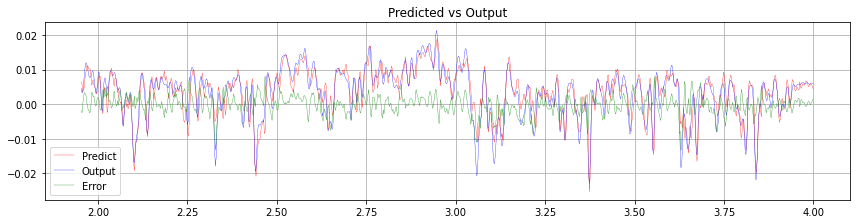

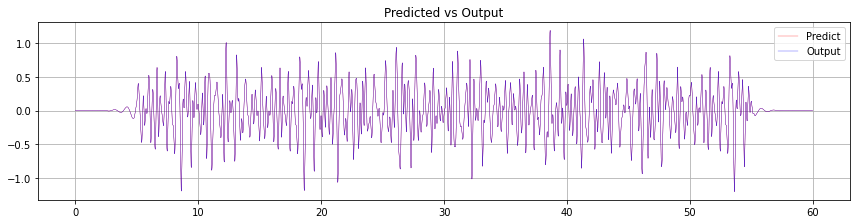

In [85]:
import matplotlib.pyplot as plt
import numpy as np
def time_series_overlay_disp(time,sig1,sig2,color1,color2,Title,label1,label2):
    fig = plt.figure(figsize=(12, 3))
    plt.plot(time, sig1,color1,linewidth=0.3, label=label1)
    plt.plot(time, sig2,color2,linewidth=0.3, label=label2) 
    plt.tight_layout()
    plt.title(Title)
    plt.grid()
    plt.legend()
    return

plt.figure(1,figsize=(50,10))
err = y_test-y_predict

time_0 = np.linspace(0,1/512*len(y_predict),len(y_predict))
time_series_overlay_disp(time_0[1000:2048],y_predict[1000:2048],y_test[1000:2048],'r','b','Predicted vs Output','Predict','Output')
plt.plot(time_0[1000:2048],err[1000:2048],'g',linewidth=0.3,label='Error')
plt.legend()

# time_series_overlay_disp(time_0,y_predict,y_test,'r','b','Predicted vs Output','Predict','Output')

time_0 = np.linspace(0,1/512*len(y_predict),len(y_predict))
time_series_overlay_disp(abc[0],abc[1],abc[1],'r','b','Predicted vs Output','Predict','Output')

# time_series_overlay_disp(abc[0],abc[2],abc[2],'r','b','Predicted vs Output','Predict','Output')


# start = np.random.random_integers(5000)
# mul = 3
# plt.plot(y_test[start:start+2048*mul],'b',y_predict[start:start+2048*mul],'r',err[start:start+2048*mul],'g')
# plt.plot(y_predict,'r',y_test,'b')

# plt.figure(2,figsize=(50,10))
# plt.plot(X_test)

print(max(y_test),max(y_predict))
print(min(y_test),min(y_predict))


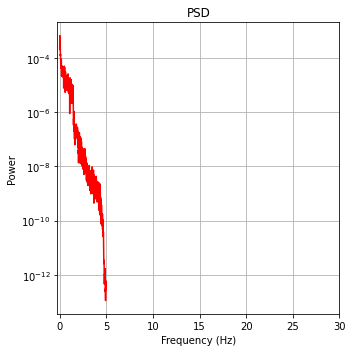

In [49]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy import signal
from scipy import fftpack
import time as ticker
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
def psd(sig,sample_rate,frames):
    return signal.welch(sig, sample_rate, window='hann',nperseg=frames)

def psd_disp(freq,psd,color,Title = None,Lo_Flimit = None,Hi_Flimit = None):
    plt.figure(figsize=(5, 5))
    plt.semilogy(freq, np.abs(psd),color)
    plt.xlim([Lo_Flimit, 30])
    plt.title(Title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.tight_layout()
    plt.grid()
    plt.tight_layout()
    return
freqs1, psd1  = psd(y_test,10,1024)

psd_disp(freqs1,psd1,'r','PSD')